In [1]:
import os, sys
sys.path.append('..')
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools
import matplotlib.pyplot as plt
# import seaborn as sns

from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

"""
Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize
"""

"\nSpot counts for cells with highly expressed genes (dense spots)\n1. Measure total intensity of every ROI after bleed-through correction and background subtraction.\n2. Calculate the number of spot from total intensity based on unit-spot intensity\n3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. \n   Spot count > cutoff: use spot count converted based on total fluorescence intensity; \n   Spot count < cutoff: use spot count from Airlocalize\n"

In [2]:
## input
input_dir = "D:\\SWAP\\Vincent\\lt171_FlpO\\gene_new_4tile\\outputs"
output_dir = os.path.join(input_dir, "testfull-aug9")  

# fixed image (directory - n5 format)
fix_dir = os.path.join(input_dir, "r2\\export_sigma3.n5")
# get appropriate image data within fix_dir
subpath='\\c3\\s2'

# registered image (directory - n5 format)
reg_dir = os.path.join(input_dir, "r1\\registration\\lt171_gene_4tile_r1-to-lt171_gene_4tile_r2\\warped")  

# segmentation mask (tif format accepted here)
lb_dir  = os.path.join(input_dir, "r2\\segmentation\\lt171_gene_4tile_r2-c3.tif" ) 

# spot dir 
spot_dir = os.path.join(input_dir, "spots_pooled") # pool spots together; warpped and fixed
intn_dir = os.path.join(input_dir, "intensities_pooled") # pool spots together; warpped and fixed
# for every gene
rounds = ['r1', 'r2']
channels = ['c0', 'c1', 'c2', 'c4']
# r1 should be the wrappped one
fx_spots = [os.path.join(spot_dir, f'spots_{r}_{c}.txt') 
                 for r, c in itertools.product(rounds, channels)]
fx_intns = [os.path.join(intn_dir, f'{r}_{c}_intensity.csv') 
                 for r, c in itertools.product(rounds, channels)]

for f in fx_spots:
    assert os.path.isfile(f)
for f in fx_intns:
    assert os.path.isfile(f)

## output
out_mask = os.path.join(output_dir, 'mask.tif')
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")
out_spots_intn = os.path.join(output_dir, "spotcount_intn.csv")
# out_intensity = os.path.join(output_dir, "intensity_c0_r2.csv")
out_spots_merged = os.path.join(output_dir, 'spotcount_merged.csv')

In [3]:
%%time
# remove C0 spots if it overlap with C4
r, c = 'r1', 'c0'
f = os.path.join(spot_dir, f'spots_{r}_{c}.txt')
query_dots = np.loadtxt(f, delimiter=',')

r, c = 'r1', 'c4'
f = os.path.join(spot_dir, f'spots_{r}_{c}.txt')
ref_dots = np.loadtxt(f, delimiter=',')

CPU times: total: 797 ms
Wall time: 808 ms


In [4]:
def remove_bleed_thru_spots(ref_dots, query_dots, epsilon=3):
    """query dots that are within epsilon distance of any ref_dots will be flagged
    epsilon distance has the unit of query/ref dots, usually in um (post-expansion)
    """
    from scipy.spatial import cKDTree
    index = cKDTree(ref_dots[:,:3])
    nn_dists, nn_ids = index.query(query_dots[:,:3], k=1)
    
    cond = nn_dists < epsilon
    print(f"{cond.sum()}/{len(cond)} = {100*cond.sum()/len(cond):.1f}% removed")
    return query_dots[~cond]

In [5]:
query_dots_new = remove_bleed_thru_spots(ref_dots, query_dots, epsilon=3)
print(query_dots_new.shape)

21515/93393 = 23.0% removed
(71878, 4)


In [6]:
%%time
from scipy.spatial import cKDTree
index = cKDTree(ref_dots[:,:3])
nn_dists, nn_ids = index.query(query_dots[:,:3], k=1)

CPU times: total: 188 ms
Wall time: 187 ms


In [7]:
nn_ids.shape, nn_dists.shape, ref_dots.shape, query_dots.shape, np.max(nn_ids)

((93393,), (93393,), (36009, 4), (93393, 4), 36009)

# find the right scale (distance) to remove

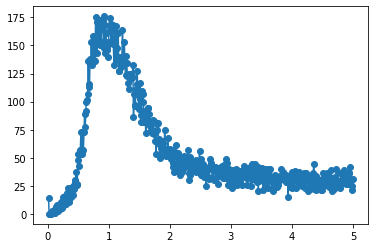

In [8]:
bins = np.linspace(0, 5, 500)
hist, _ = np.histogram(nn_dists, bins=bins)
plt.plot(bins[1:], hist, '-o')

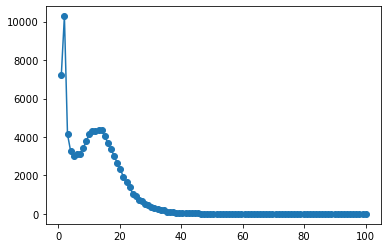

In [9]:
bins = np.linspace(0, 100, 100)
hist, _ = np.histogram(nn_dists, bins=bins)
plt.plot(bins[1:], hist, '-o')

In [10]:
cond = nn_dists < 3

In [11]:
epsilon = 3
cond = nn_dists < epsilon
cond.sum(), len(cond), cond.sum()/len(cond)

(21515, 93393, 0.23037058451918238)

In [12]:
query_dots[~cond].shape, query_dots[cond].shape

((71878, 4), (21515, 4))

In [13]:
np.nanpercentile(query_dots, 99, axis=0, ) #.nanmax(axis=0)

array([817.73714233, 753.7156311 , 830.7754718 , 875.01107666])

In [14]:
np.nanpercentile(query_dots, 1, axis=0, ) #.nanmax(axis=0)

array([-10.49858918,  31.31003098,   7.224967  , 117.44403015])